### Objectifs de ce notebook :
>Utilisation des données du site https://data.cityofchicago.org/ sur la criminalité ainsi que des données  socio-économiques du ministère de la Santé de Chicago https://data.cityofchicago.org/Health-Human-Services/Census-Data-Selected-socioeconomic-indicators-in-C/kn9c-c2s2.
- Explication des variables (nom des colonnes)
- Visualisation des différentes données 
- Détection des différentes corrélations entre les variables
- Agrégation du nombre de crime par mois, par région et par type
- Visualisation

In [1]:
# traitement des données
import pandas as pd
import numpy as np
# Visualisation
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from folium import plugins
from folium.plugins import MarkerCluster, FastMarkerCluster, HeatMapWithTime

In [2]:
Path_Socio = "../data/raw/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv"
Path_Crime = "../data/raw/Crimes_-_2001_to_present.csv"
Path_geo_json = "../data/raw/chicago_police_districts.geojson"
df_Socio = pd.read_csv(Path_Socio)
df_Crime = pd.read_csv(Path_Crime, sep=';')

In [3]:
def rename_columns_socio():
    """
    
    """
    return {
'Community Area Number':'community_area_number',
'COMMUNITY AREA NAME':'community_area_name', 
'PERCENT OF HOUSING CROWDED':'pct_housing_crowded', 
'PERCENT HOUSEHOLDS BELOW POVERTY':'pct_households_below_poverty', 
'PERCENT AGED 16+ UNEMPLOYED':'pct_age16_unemployed',
'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA':'pct_age25_no_highschool',
'PERCENT AGED UNDER 18 OR OVER 64': 'pct_not_working_age',
'per_capita_income':'per_capita_income',
'HARDSHIP INDEX' : 'hardship_index'}

def rename_columns_crimes():
    """
    
    """
    return {
        'ID': 'id',
        'Case Number': 'cas_number', 
        'Date':'date',
        'Block':'block', 
        'IUCR':'iucr', 
        'Primary Type':'primary_type',
        'Description':'description', 
        'Location Description':'location_description', 
        'Arrest':'arrest', 
        'Domestic':'domestic', 
        'Beat':'beat',
        'District':'district', 
        'Ward':'ward', 
        'Community Area': 'community_area_number', 
        'FBI Code':'fbi_code', 
        'X Coordinate':'x_coordinate',
        'Y Coordinate':'y_coordinate', 
        'Year':'year', 
        'Updated On':'updated_on', 
        'Latitude':'latitude', 
        'Longitude':'longitude',
        'Location':'location'   
    }

df_Socio.rename(columns=rename_columns_socio(), inplace = True)
df_Crime.rename(columns= rename_columns_crimes(), inplace= True)

In [4]:
def merge_crime_socio(year, df_S, df_C):
    """
    
    """
    df_year = df_Crime[df_C['year']==year]
    df_merged = pd.merge(df_year, df_S, on ='community_area_number', how='inner')
    df_merged.dropna(inplace=True)
    del df_year
    return  df_merged
    
def crimes_socio_by_region(year, df_S, df_C):
    """
    
    """
    df_merged = merge_crime_socio(year, df_S, df_C)
    df_merged_agg = df_merged.groupby(['community_area_number', 'community_area_name'], as_index=False).agg({'id':'count'})
    del df_merged
    df_merged_agg.rename(columns={"id" : "crimes_nb_by_region"}, inplace = True)
    return df_merged_agg

def crimes_by_type(df_C):
    """
    
    """
    df_grouped = df_C.groupby('primary_type',as_index=False).agg({'id': "count"})
    df_grouped.rename(columns = {"id" : "crimes_nb"}, inplace = True)
    return df_grouped

def crimes_by_month(year, df_C):
    """
    
    """
    df = df_C[['date', 'id','year']]
    df_year = df[df['year']==year]
    df_year['month'] = pd.DatetimeIndex(df_year['date']).month
    del df
    df_grouped = df_year.groupby('month', as_index=False).agg({'id': "count"})
    del df_year
    df_grouped.rename(columns = {"id" : "crimes_nb"}, inplace = True)
    return df_grouped
    
def crimes_socio_by_type_region(year, df_S, df_C):
    """
    
    """
    df_merged = merge_crime_socio(year, df_S, df_C)
    df_merged_agg = df_merged.groupby(['community_area_number', 'community_area_name', 'primary_type'],\
                                      as_index=False).agg({'id':'count'})
    del df_merged
    df_merged_agg.rename(columns = {"id" : "crimes_nb_by_type_region"}, inplace=True)
    return df_merged_agg

In [5]:
df_test=crimes_by_month(year=2012, df_C=df_Crime)

/home/ml/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
del df_test

## Visualisation : histogramme des crimes par type

In [6]:
df_by_type = crimes_by_type(df_C=df_Crime)

In [7]:
df_by_type.sample(3)

,primary_type,crimes_nb
2,BATTERY,1211752
30,ROBBERY,251687
34,WEAPONS VIOLATION,68353


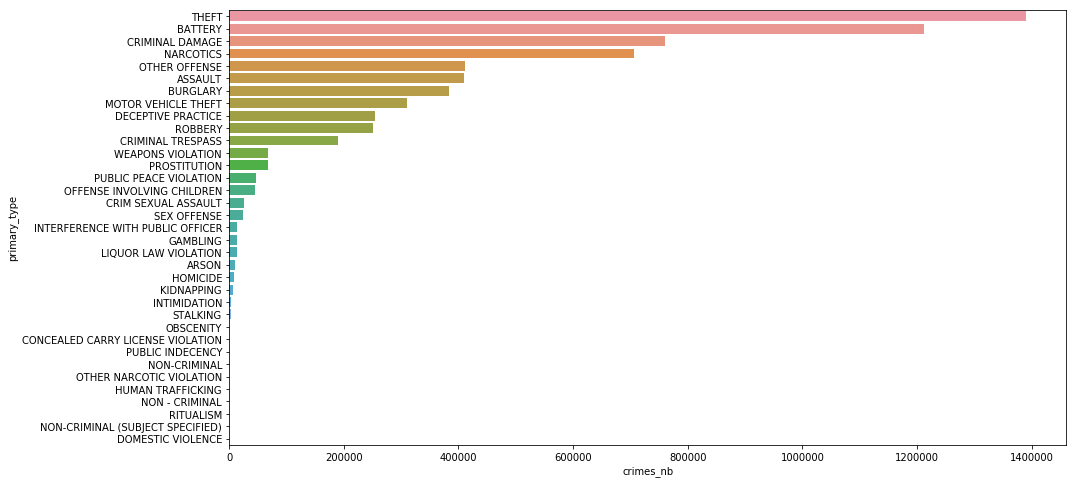

In [8]:
plt.figure(figsize=(15,8))
sns.barplot(x="crimes_nb", y='primary_type', data=df_by_type.sort_values('crimes_nb', ascending=False), ci=None)

## Visualisation : histogramme des crimes par région

In [9]:
df_by_region = crimes_socio_by_region(year=2012, df_S=df_Socio, df_C=df_Crime)

In [10]:
df_by_region.head(5)

,community_area_number,community_area_name,crimes_nb_by_region
0,1.0,Rogers Park,4919
1,2.0,West Ridge,4024
2,3.0,Uptown,4961
3,4.0,Lincoln Square,2325
4,5.0,North Center,1916


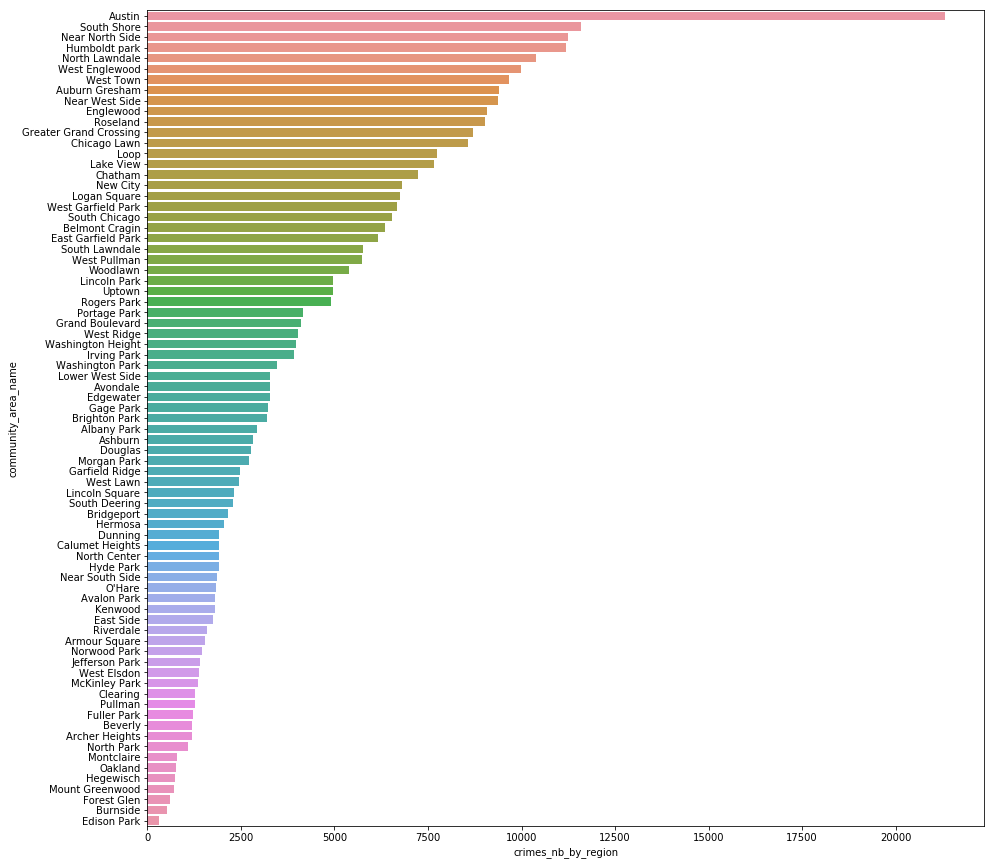

In [11]:
plt.figure(figsize=(15,15))
sns.barplot(x="crimes_nb_by_region", y='community_area_name', data=df_by_region.sort_values('crimes_nb_by_region', ascending=False), ci=None)

## Visualisation croisée des données socio-économique

/home/ml/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/ml/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/ml/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


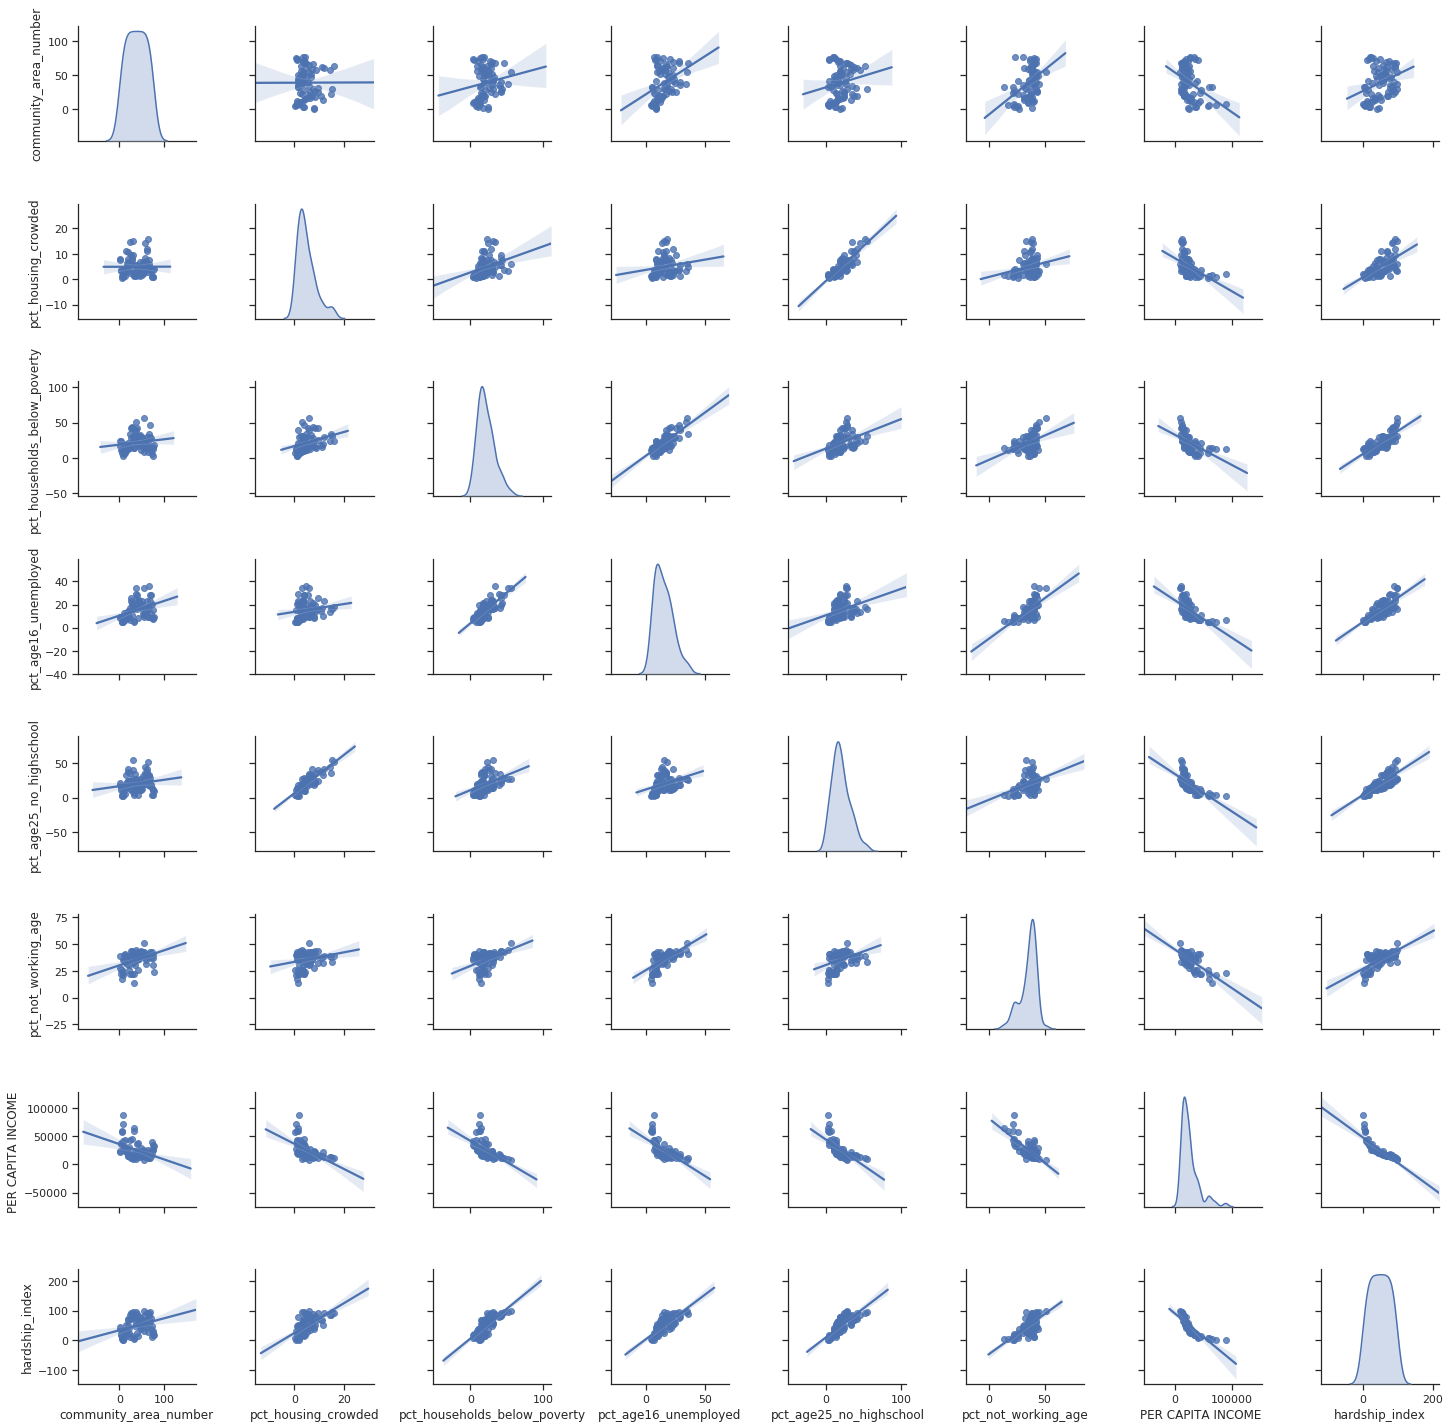

In [12]:
sns.set(style='ticks', color_codes=True)
sns.pairplot(df_Socio, diag_kind='kde', kind='reg')

## Visualisation des crime par mois sur une année

In [13]:
df_by_month = crimes_by_month(year=2012, df_C=df_Crime)

/home/ml/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
df_by_month.head(3)

,month,crimes_nb
0,1,26242
1,2,23860
2,3,28553


/home/ml/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


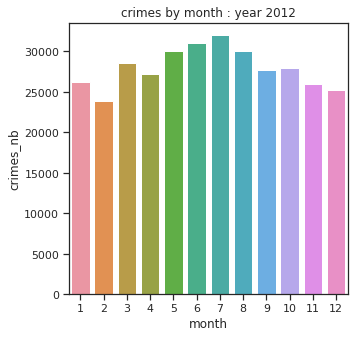

In [15]:
plt.figure(figsize=(5,5))
plt.title("crimes by month : year 2012")
sns.barplot(x="month", y='crimes_nb', data=crimes_by_month(year=2012, df_C=df_Crime).sort_values('crimes_nb', ascending=False), ci=None)

/home/ml/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


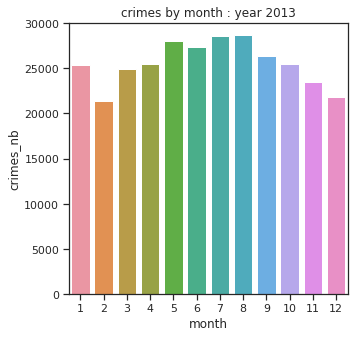

In [16]:
plt.figure(figsize=(5,5))
plt.title("crimes by month : year 2013")
sns.barplot(x="month", y='crimes_nb', data=crimes_by_month(year=2013, df_C=df_Crime).sort_values('crimes_nb', ascending=False), ci=None)

/home/ml/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


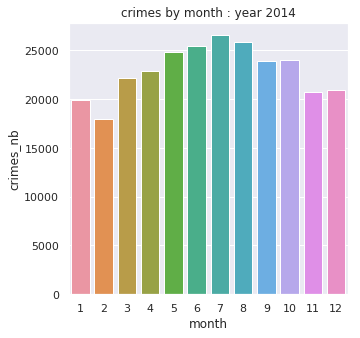

In [28]:
plt.figure(figsize=(5,5))
plt.title("crimes by month : year 2014")
sns.barplot(x="month", y='crimes_nb', data=crimes_by_month(year=2014, df_C=df_Crime).sort_values('crimes_nb', ascending=False), ci=None)

In [29]:
import folium

In [30]:
df_Crime.shape

(6636709, 22)

In [31]:
list(df_Crime.columns)

['id',
 'cas_number',
 'date',
 'block',
 'iucr',
 'primary_type',
 'description',
 'location_description',
 'arrest',
 'domestic',
 'beat',
 'district',
 'ward',
 'community_area_number',
 'fbi_code',
 'x_coordinate',
 'y_coordinate',
 'year',
 'updated_on',
 'latitude',
 'longitude',
 'location']

In [32]:
df_Crime['primary_type'].unique()

array(['BATTERY', 'OTHER OFFENSE', 'ROBBERY', 'NARCOTICS',
       'CRIMINAL DAMAGE', 'WEAPONS VIOLATION', 'THEFT', 'BURGLARY',
       'MOTOR VEHICLE THEFT', 'PUBLIC PEACE VIOLATION',
       'DECEPTIVE PRACTICE', 'ASSAULT', 'CRIMINAL TRESPASS',
       'CRIM SEXUAL ASSAULT', 'INTERFERENCE WITH PUBLIC OFFICER', 'ARSON',
       'LIQUOR LAW VIOLATION', 'KIDNAPPING', 'SEX OFFENSE',
       'OFFENSE INVOLVING CHILDREN', 'PROSTITUTION', 'HOMICIDE',
       'GAMBLING', 'INTIMIDATION', 'STALKING', 'OBSCENITY',
       'PUBLIC INDECENCY', 'HUMAN TRAFFICKING',
       'CONCEALED CARRY LICENSE VIOLATION', 'OTHER NARCOTIC VIOLATION',
       'NON - CRIMINAL', 'NON-CRIMINAL', 'RITUALISM',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'DOMESTIC VIOLENCE'],
      dtype=object)

In [33]:
df_homicide = df_Crime[df_Crime['primary_type']=='HOMICIDE']
df_homicide = df_homicide.loc[(df_homicide['x_coordinate']!=0)]

/home/ml/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'All Homicides (2001-2018) per District')

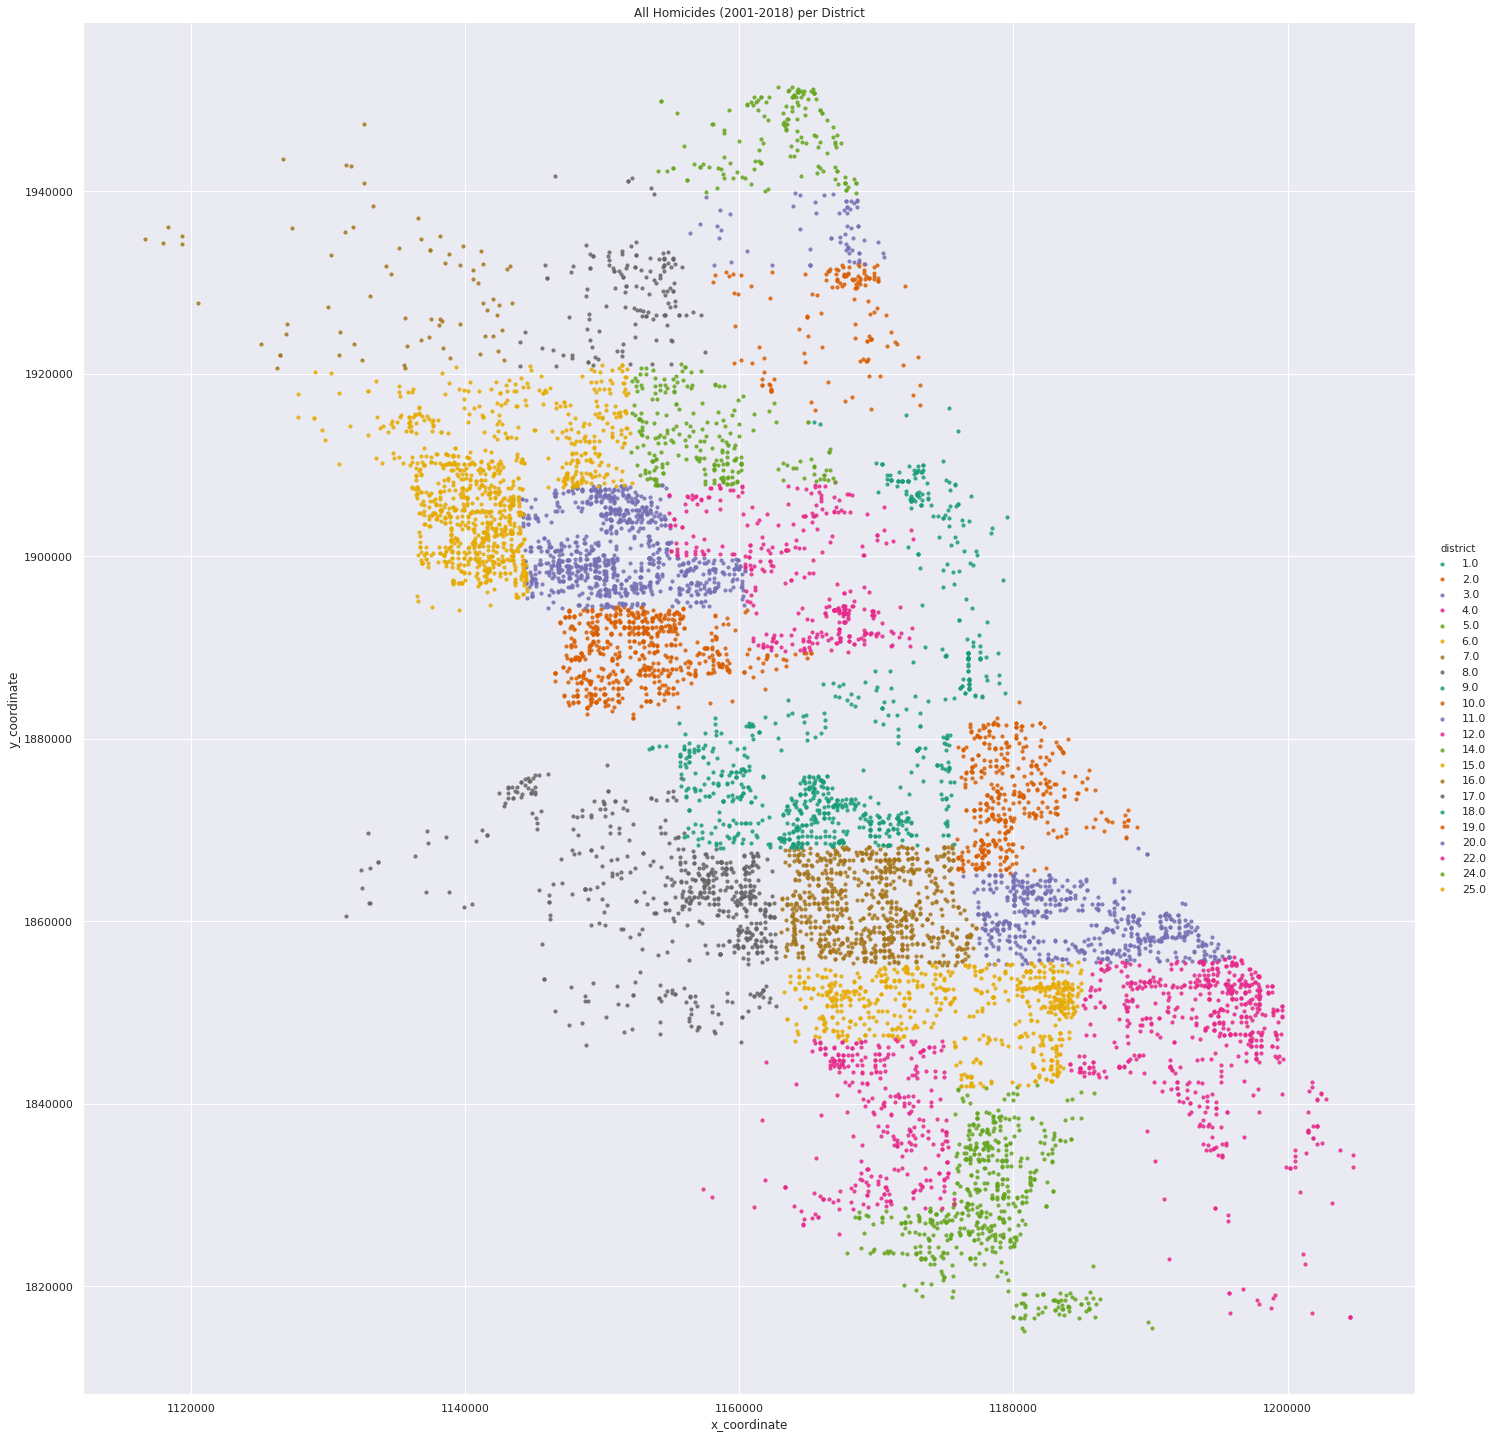

In [34]:
sns.lmplot('x_coordinate',
           'y_coordinate',
           data=df_homicide[:],
           fit_reg=False, 
           hue="district", 
           palette='Dark2',
           size=20,
           ci=2,
           scatter_kws={"marker": "D", 
                        "s": 10}) 
ax = plt.gca()
ax.set_title("All Homicides (2001-2018) per District")

Text(0.5, 1.0, 'CHICAGO MURDER RATES: 2001 - 2018')

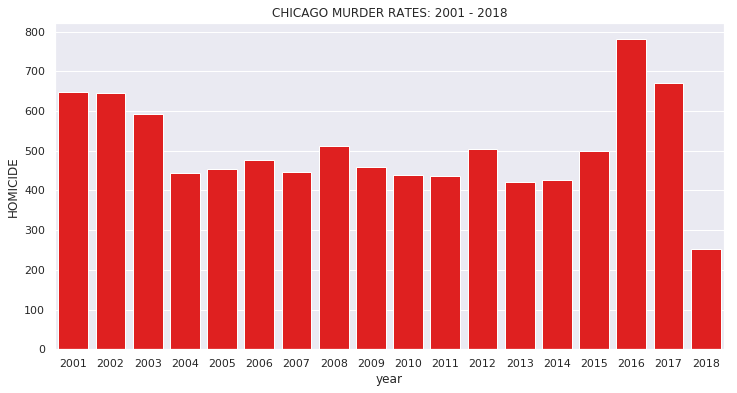

In [35]:
plt.figure(figsize=(12,6))
sns.barplot(x='year',
            y='HOMICIDE',
            data=df_homicide.groupby(['year'])['primary_type'].value_counts().\
                 unstack().reset_index(),
            color='red').\
            set_title("CHICAGO MURDER RATES: 2001 - 2018")

Text(0.5, 1.0, 'HOMICIDE vs DISTRICT vs YEAR')

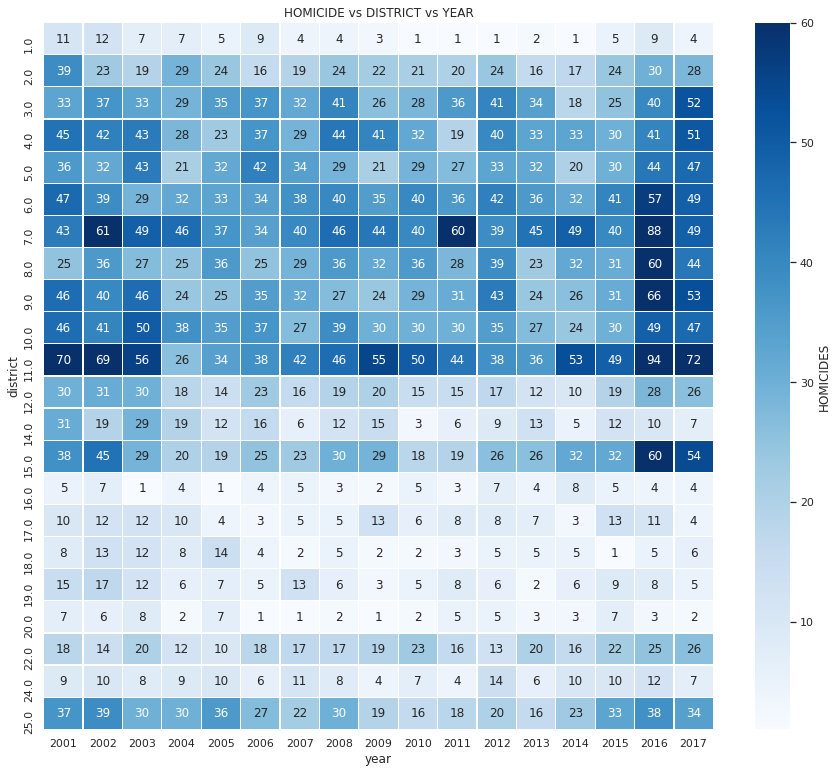

In [36]:
# create a heatmap showing crime by district by year
corr = df_homicide.groupby(['district','year']).count().date.unstack()
fig, ax = plt.subplots(figsize=(15,13))
sns.set(font_scale=1.0)
sns.heatmap(corr.dropna(axis=1),
            annot=True,
           linewidths=0.2,
           cmap='Blues',
            robust=True,
           cbar_kws={'label': 'HOMICIDES'})
plt.title('HOMICIDE vs DISTRICT vs YEAR')



In [37]:
df_Crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636709 entries, 0 to 6636708
Data columns (total 22 columns):
id                       int64
cas_number               object
date                     object
block                    object
iucr                     object
primary_type             object
description              object
location_description     object
arrest                   bool
domestic                 bool
beat                     int64
district                 float64
ward                     float64
community_area_number    float64
fbi_code                 object
x_coordinate             float64
y_coordinate             float64
year                     int64
updated_on               object
latitude                 float64
longitude                float64
location                 object
dtypes: bool(2), float64(7), int64(3), object(10)
memory usage: 1.0+ GB


In [38]:
import datetime

In [39]:
%%time
df_homicide['date'] = df_homicide['date'].apply(lambda x: datetime.datetime.strptime(x,"%m/%d/%Y %I:%M:%S %p"))
df_homicide.head()

CPU times: user 218 ms, sys: 0 ns, total: 218 ms
Wall time: 614 ms


In [40]:
%%time 
df_Crime['date'] = df_Crime['date'].apply(lambda x: datetime.datetime.strptime(x,"%m/%d/%Y %I:%M:%S %p"))

CPU times: user 1min 4s, sys: 355 ms, total: 1min 4s
Wall time: 1min 21s


In [41]:
df_homicide['year'] = df_homicide['date'].dt.year
df_homicide['month'] = df_homicide['date'].dt.month
df_homicide['day'] = df_homicide['date'].dt.day
df_homicide['weekday'] = df_homicide['date'].dt.dayofweek
df_homicide['hourOfDay'] = df_homicide['date'].dt.hour
df_homicide = df_homicide.sort_values('date')
df_homicide.sample(5)

,id,cas_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,y_coordinate,year,updated_on,latitude,longitude,location,month,day,weekday,hourOfDay
2142404,1669,HH563384,2002-08-07 03:38:00,071XX S UNIVERSITY AVE,0110,HOMICIDE,FIRST DEGREE MURDER,AUTO,True,False,...,1857890.0,2002,08/17/2015 03:03:40 PM,41.765202,-87.597046,"(41.76520163, -87.597045801)",8,7,2,3
3813712,4259,HN591790,2007-09-16 02:52:00,090XX S PAULINA ST,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,...,1844749.0,2007,08/17/2015 03:03:40 PM,41.729556,-87.665312,"(41.729555894, -87.665312002)",9,16,6,2
2362471,2002,HJ168975,2003-02-06 16:30:00,035XX W BELDEN AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,...,1915070.0,2003,08/17/2015 03:03:40 PM,41.922809,-87.714093,"(41.922809197, -87.714093149)",2,6,3,16
2372799,20577,HV435850,2012-08-18 10:37:00,002XX S ROCKWELL ST,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,...,1898797.0,2012,08/17/2015 03:03:40 PM,41.878026,-87.691106,"(41.878025954, -87.691105827)",8,18,5,10
3207151,3304,HL547533,2005-08-13 21:20:00,028XX N MASON AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,...,1918362.0,2005,08/17/2015 03:03:40 PM,41.932154,-87.774781,"(41.932154451, -87.774781254)",8,13,5,21


In [42]:
df_homicide.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9111 entries, 698171 to 991429
Data columns (total 26 columns):
id                       9111 non-null int64
cas_number               9110 non-null object
date                     9111 non-null datetime64[ns]
block                    9111 non-null object
iucr                     9111 non-null object
primary_type             9111 non-null object
description              9111 non-null object
location_description     9111 non-null object
arrest                   9111 non-null bool
domestic                 9111 non-null bool
beat                     9111 non-null int64
district                 9111 non-null float64
ward                     8777 non-null float64
community_area_number    8777 non-null float64
fbi_code                 9111 non-null object
x_coordinate             9108 non-null float64
y_coordinate             9108 non-null float64
year                     9111 non-null int64
updated_on               9111 non-null object
latitu

In [43]:
# plot chloropleth maps for all full years in dataset
from IPython.display import IFrame

def toString(x):
    return str(int(x))

df_homicide_allyears = df_homicide.groupby(['district']).count().arrest.reset_index()
df_homicide_allyears['district'] = df_homicide_allyears['district'].apply(toString)

# ______________________________________________________#

chicago = location=[41.85, -87.68]
m = folium.Map(chicago,
               zoom_start=10)

plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True).add_to(m)

m.choropleth(
    geo_data=Path_geo_json,
    name='choropleth',
    data=df_homicide_allyears,
    columns=['district', 'arrest'],
    key_on='feature.properties.dist_num',
    fill_color='YlOrRd', 
    fill_opacity=0.4, 
    line_opacity=0.2,
    legend_name='Choropleth of Homicide per Police District : 2001-2017',
    highlight=True
    )
folium.TileLayer('openstreetmap').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)
folium.LayerControl().add_to(m)
m.save("map1.html") 
IFrame('map1.html', width=990, height=700)

/home/ml/anaconda3/lib/python3.7/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [44]:
df_homicide_2018 = df_homicide[df_homicide['year']==2018].groupby(['district']).count().arrest.reset_index()
df_homicide_2018['district'] = df_homicide_2018['district'].apply(toString)

In [45]:
# geo locations of homicides -- January, February 2018



only_2018 = df_homicide[df_homicide['year']==2018].dropna()

# _____________________________________________

lats = list(only_2018.latitude)
longs = list(only_2018.longitude)
locations = [lats,longs]

m = folium.Map(
    location=[np.mean(lats), np.mean(longs)],
    zoom_start=10.3
)

plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True).add_to(m)

FastMarkerCluster(data=list(zip(lats, longs))).add_to(m)

m.choropleth(
    geo_data=Path_geo_json,
    name='choropleth',
    data=df_homicide_2018,
    columns=['district', 'arrest'],
    key_on='feature.properties.dist_num',
    fill_color='YlOrRd', 
    fill_opacity=0.4, 
    line_opacity=0.2,
    legend_name='Homicides : January, February 2018',
    highlight=False
    )

# folium.TileLayer('openstreetmap').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)
folium.LayerControl().add_to(m)
m.save("map6.html") 
IFrame('map6.html', width=990, height=700)

/home/ml/anaconda3/lib/python3.7/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [46]:
# geo locations of homicides crime scenes -- 2016-2017

df_homicide_after_2015 = df_homicide[df_homicide['year']>=2000].groupby(['district']).count().arrest.reset_index()
df_homicide_after_2015['district'] = df_homicide_after_2015['district'].apply(toString)

after_2015 = df_homicide[df_homicide['year']>=2000].dropna()

# _____________________________________________

lats = list(after_2015.latitude)
longs = list(after_2015.longitude)
locations = [lats,longs]

m = folium.Map(
    location=[np.mean(lats), np.mean(longs)],
    zoom_start=10.3
)

plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True).add_to(m)

FastMarkerCluster(data=list(zip(lats, longs))).add_to(m)

m.choropleth(
    geo_data=Path_geo_json,
    name='choropleth',
    data=df_homicide_after_2015,
    columns=['district', 'arrest'],
    key_on='feature.properties.dist_num',
    fill_color='YlOrRd', 
    fill_opacity=0.4, 
    line_opacity=0.2,
    legend_name='Homicides : 2016-2017',
    highlight=False
    )

# folium.TileLayer('openstreetmap').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)
folium.LayerControl().add_to(m)
m.save("map5.html") 
IFrame('map5.html', width=990, height=700)

/home/ml/anaconda3/lib/python3.7/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [47]:
# plot yearly time lapse heatmap all districts -- (2001-2017)

chicago = location=[41.85, -87.68]
m = folium.Map(chicago, zoom_start=9.5,control_scale = False)

plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True).add_to(m)
   
m.choropleth(
    geo_data=Path_geo_json,
    name='choropleth',
    data=df_homicide_allyears,
    columns=['district', 'arrest'],
    key_on='feature.properties.dist_num',
    fill_color='YlOrRd', 
    fill_opacity=0.2, 
    line_opacity=0.2,
    legend_name='Homicides : 2001-2017',
    highlight=True
    )

heat_df = df_homicide[df_homicide['year']>=2001].reset_index()
heat_df = heat_df[['latitude', 'longitude','year']]
heat_df['Weight'] = heat_df['year'].astype(float)
heat_df = heat_df.dropna(axis=0, subset=['latitude','longitude', 'Weight'])
heat_data = [[[row['latitude'],row['longitude']] for index, row in\
            heat_df[heat_df.Weight == i].iterrows()] for i in range(2001,2018)]

m.add_child(plugins.HeatMapWithTime(data=heat_data,
                                   auto_play=True,
                                   max_opacity=0.8,
                                   display_index=True,
                                   radius=9,
                                   name='HeatMapWithTime')
           )
folium.TileLayer('cartodbpositron').add_to(m)
folium.LayerControl().add_to(m)
m.save("map4.html") 
IFrame('map4.html', width=990, height=700)

/home/ml/anaconda3/lib/python3.7/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
